## Efficient Low Noise Neural Network

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import Image
import pprint as pp
import random
import time
import sys
import os
try:
   import cPickle as cPickle
except:
   import pickle as cPickle

### Load data

In [35]:
data = pd.read_csv('dataset/processed_pos_neg_reviews.csv', encoding='latin-1')

In [36]:
data.head()

,ProductId,Rating,Summary,Text,Label
0,B003NV4O00,5,"No MSG, No corn syrup, and yummy & vegan","Unlike many products from Asia, this source ha...",POSITIVE
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,B003MOXA6C,4,Healthy snack,"This low sugar, high fiber tasty treat tastes ...",POSITIVE
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,B001ELLAW6,5,Great margarita and sangria sugar,I use caster sugar in my sangria and margarita...,POSITIVE


In [37]:
data.Label.value_counts()

POSITIVE    82037
NEGATIVE    82037
Name: Label, dtype: int64

### Data Preparation

Training Data

In [38]:
# first 70000 reviews
training_data = data[0:70000].reset_index(drop=True)
training_data_length = training_data.shape[0]
training_data.head()

,ProductId,Rating,Summary,Text,Label
0,B003NV4O00,5,"No MSG, No corn syrup, and yummy & vegan","Unlike many products from Asia, this source ha...",POSITIVE
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,B003MOXA6C,4,Healthy snack,"This low sugar, high fiber tasty treat tastes ...",POSITIVE
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,B001ELLAW6,5,Great margarita and sangria sugar,I use caster sugar in my sangria and margarita...,POSITIVE


Shape of training data

In [39]:
pp.pprint(training_data.shape)
pp.pprint(training_data.Label.shape)

(70000, 5)
(70000,)


Validation Data

In [40]:
# middle 6019 reviews
validation_data = data[70000:76019].reset_index(drop=True)
validation_data_length = validation_data.shape[0]
validation_data.head()

,ProductId,Rating,Summary,Text,Label
0,B001228QE2,5,Finally Found it!,I used to be able to purchase this soup in my ...,POSITIVE
1,B001VJ0B0I,2,"Gross by-products, sugar, and food colorings--...",I completely agree that the ingredients for th...,NEGATIVE
2,B0029XDZDK,3,"Funny name, plain old coffee",Picked up a case of this just because the name...,POSITIVE
3,B001VJ0B0I,2,Read the Ingredient List,Make sure you read the list of ingredients bef...,NEGATIVE
4,B000K1QZL2,4,Flakey,A good tasting biscuit but pretty messy to eat...,POSITIVE


Shape of validation data

In [41]:
pp.pprint(validation_data.shape)
pp.pprint(validation_data.Label.shape)

(6019, 5)
(6019,)


Testing data

In [42]:
# last 6018 reviews
test_data = data[76019:82037].reset_index(drop=True)
test_data_length = test_data.shape[0]
test_data.head()

,ProductId,Rating,Summary,Text,Label
0,B003NV2IG2,2,Inconsistent Taste,I first tasted Annie Chun's seaweed three year...,NEGATIVE
1,B005Q8IXXM,3,ReGen Chocolate muscle recovery,I could not drink this as it has to much sugar...,POSITIVE
2,B003NV2IG2,2,"Nothing like sushi, that's for sure","For me, these were a total bust. The texture s...",NEGATIVE
3,B0029NII3C,4,Four Paws up,"I have owned cats all my life, and over the ye...",POSITIVE
4,B003NV2IG2,2,Mediocre for Seaweed Snacking,This is one of many varieties of seaweed snack...,NEGATIVE


Shape of Testing data

In [43]:
pp.pprint(test_data.shape)
pp.pprint(test_data.Label.shape)

(6018, 5)
(6018,)


### Analysing Ineffiencies in Network

#### Pruning

Given the volume of our data, the training speed is still pretty low and have to find ways to increment it. Since, effectively, **0 multiplied by any number is still 0**, we could find a way to disregard inputs that are **0** and only consider those with **1**. 

This will improve our computation time allowing us to train on even more data.

#### Eficient and Low Noise SentimentalNetwork

In [44]:
# Let's tweak our network from before to model these phenomena
class EfficientLowNoiseSentimentalNeuralNetwork(object):
    def __init__(self, training_data, num_hidden_nodes=10, num_epochs=10, learning_rate=0.1, min_count=10,polar_cutoff=0.1):
        # set our random number generator 
        np.random.seed(1)
        # set our improvement parameters
        self.min_count = min_count
        # ToDo -cater different centers of the frquency ditribution
        self.polar_cutoff = polar_cutoff
        # pre-process data
        self.pre_process_data(training_data)
        
        # set network paramaters
        self.num_features = len(self.vocab)
        self.vocab_vector = np.zeros((1, len(self.vocab)))
        self.num_input_nodes = self.num_features
        self.num_hidden_nodes = num_hidden_nodes
        self.num_epochs = num_epochs
        self.num_output_nodes = 1
        self.learning_rate = learning_rate
        
        # for printing later
        self.losses = {'train':[], 'validation':[]}
        self.accuracy = {'train':[], 'validation':[]}
        self.confusion_matrix = np.zeros((1,4))
        # initialize weights
        self.weights_i_h = np.random.randn(self.num_input_nodes, self.num_hidden_nodes)
        self.weights_h_o = np.random.randn(self.num_hidden_nodes, self.num_output_nodes)
         # initialize weights
        self.bias_i_h = np.zeros(self.num_hidden_nodes)
        self.bias_h_o = np.zeros(self.num_output_nodes)
        # initialise the hidden layer with zeros
        self.hidden_layer = np.zeros((self.num_output_nodes, self.num_hidden_nodes))
        
    def forward_backward_propagate(self, text, label):
        ### Forward pass ###
        # Input Layer & Hidden layer operation
        self.hidden_layer *= 0
        for index in text:
            self.hidden_layer += self.weights_i_h[index]
        self.hidden_layer += self.bias_i_h
            
        # Output layer
        output_layer = self.sigmoid(self.hidden_layer.dot(self.weights_h_o) + self.bias_h_o)
        
        ### Backward pass ###
        # Output error
        output_layer_error = output_layer - self.get_target_for_label(label)
        output_layer_delta = output_layer_error * self.sigmoid_derivative(output_layer)

        # Backpropagated error - to the hidden layer
        hidden_layer_error = output_layer_delta.dot(self.weights_h_o.T)
        # hidden layer gradients - no nonlinearity so it's the same as the error
        hidden_layer_delta = output_layer_error 

        # update the weights and bias - with grdient descent
        self.weights_h_o -= self.hidden_layer.T.dot(output_layer_delta) * self.learning_rate 
        self.bias_h_o -= output_layer_delta[0] * self.learning_rate 
        # update only the weights and bias used in the forward pass
        for index in text:
            self.weights_i_h[index] -= hidden_layer_delta[0] * self.learning_rate
        self.bias_i_h -= hidden_layer_delta[0] * self.learning_rate
        
        if(output_layer >= 0.5 and self.get_target_for_label(label) == 1):
                self.correct_so_far += 1
        elif(output_layer < 0.5 and self.get_target_for_label(label) == 0):
                self.correct_so_far += 1
        
    def train(self):
        # process data to eliminate zero's
        training_data_text = list()
        for review in training_data.Text:
            indices = set()
            for word in review.split(" "):
                if(word in self.word_to_column.keys()):
                    indices.add(self.word_to_column[word])
            training_data_text.append(list(indices))
        
        # iterate through all epochs
        for epoch in range(self.num_epochs):
            self.correct_so_far = 0
            start = time.time()
            training_loss = 0
            validation_loss = 0
            training_accuracy = 0

            # train over all rows of training data
            for row in range(training_data.shape[0]):
                # Forward and Back Propagation
                self.forward_backward_propagate(training_data_text[row], training_data.Label[row])
                # calculate our speed
                elasped_time = float(time.time() - start + 0.001)
                samples_per_second = row / float(elasped_time)
                # calculate our accuracy
                training_accuracy = self.correct_so_far * 100 / float(row+1)
                # print progress of training
                sys.stdout.write("\rEpoch: "+ str(epoch)
                                 + " Progress: " + str(100 * row/float(training_data.shape[0]))[:4] + "%"
                                 + " Speed(samples/sec): " + str(samples_per_second)[0:5] 
                                 + " #Correct: " + str(self.correct_so_far) 
                                 + " #Trained: " + str(row+1) 
                                 + " Training Accuracy: " + str(training_accuracy)[:4] + "%")
            
            self.accuracy["train"].append(training_accuracy) 
                
            training_loss = self.run(training_data[0:7000])
            validation_loss = self.run(validation_data,  mode="validate")
            self.losses["train"].append(training_loss)
            self.losses["validation"].append(validation_loss)      
            print("")
            
    def run(self, input_data, mode="train"):
        # total losses for sample
        val_correct_so_far = 0
        val_accuracy = 0
        loss = 0
        # iterate through all training samples
        for row in range(0, input_data.shape[0]):
            # get prediction
            pred = self.predict(input_data.Text[row])
            # calculate the loss
            loss += np.mean((pred - self.get_target_for_label(input_data.Label[row]))**2)
            # Calculate our accuracy
            if(mode is "validate"):
                #calculate the accuracy
                if(pred >= 0.5 and self.get_target_for_label(input_data.Label[row]) == 1):
                    val_correct_so_far += 1
                elif(pred < 0.5 and self.get_target_for_label(input_data.Label[row]) == 0):
                    val_correct_so_far += 1
        if(mode is "validate"):
            val_accuracy = val_correct_so_far * 100 / float(input_data.shape[0])
            self.accuracy["validation"].append(val_accuracy) 
        return loss/float(input_data.shape[0]) 
            
            
    def test(self, test_data):
        # How many predictions are correct out of total training
        correct = 0
        # Reset cnfusion matrix 
        self.confusion_matrix = np.zeros((1,4))
        # start time of one epoch
        start = time.time()
        # iterate through all training samples
        for i in range(0, test_data.shape[0]):
            # get prediction
            pred = self.predict(test_data.Text[i])
            # count how many we validate as correct
            if(pred >= 0.5 and self.get_target_for_label(test_data.Label[i]) == 1):
                correct += 1
            elif(pred < 0.5 and self.get_target_for_label(test_data.Label[i]) == 0):
                correct += 1
            # create confusion matrix    
            self.confusion_matrix += self.calculate_confusion_matrix(np.rint(pred), self.get_target_for_label(test_data.Label[i]))
            # calculate our sampling rate
            reviews_per_second = i / float(time.time() - start + 0.001)
            # print out the validation metrics
            sys.stdout.write("\rProgress:" + str(100 * i/float(test_data.shape[0]))[:4] + "%"
                             + " Speed(reviews/sec):" + str(reviews_per_second)[0:5] 
                             + " #Correct:" + str(correct) 
                             + " #Tested:" + str(i+1) 
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
            
    def predict(self, text):
        # prepare the data
        indices = set()
        for word in text.split(" "):
            if(word in self.word_to_column.keys()):
                indices.add(self.word_to_column[word])
        
        ### Forward pass ###
        # Input Layer & Hidden layer operation
        self.hidden_layer *= 0
        for index in indices:
            self.hidden_layer += self.weights_i_h[index]
        self.hidden_layer += self.bias_i_h

        # output layer
        output_layer = self.sigmoid(self.hidden_layer.dot(self.weights_h_o) + self.bias_h_o)
        
        return output_layer.flatten()
    
    
    def visualise_training(self):
        plt.figure(1)
        plt.title('Training, LR: ' + str(self.learning_rate) + ' HLU: ' + str(self.num_hidden_nodes))
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(self.losses['train'], label='Training loss')
        plt.plot(self.losses['validation'], label='Validation loss')
        plt.legend()
        
        file_path = "training/plot_loss_lr" + str(self.learning_rate) + "epoch_" + str(self.num_epochs)+ "hlu_" + str(self.num_hidden_nodes) + ".png"
        self.save_plot(file_path)
        
        plt.figure(2)
        plt.title('Training, LR: ' + str(self.learning_rate) + ' HLU: ' + str(self.num_hidden_nodes))
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(self.accuracy['train'], label='Training Accuracy')
        plt.plot(self.accuracy['validation'], label='Validation Accuracy')
        plt.legend()
        
        file_path = "training/plot_acc_lr" + str(self.learning_rate) + "epoch_" + str(self.num_epochs) + "hlu_" + str(self.num_hidden_nodes) + ".png"
        self.save_plot(file_path)
        
    def save_plot(self, file_path):
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(file_path, bbox_inches='tight')
                      
    def get_confusion_matrix(self):
        hyper_param_dict = {'EP':self.num_epochs, 'LR':self.learning_rate, 'HLU': self.num_hidden_nodes}
        df = pd.DataFrame(data=[hyper_param_dict], columns=['EP', 'LR', 'HLU'])
        
        tmp_df = pd.DataFrame(data=self.confusion_matrix, columns=['TP','FP', 'TN', 'FN'])
        # combine the rows, not columns i.e axis=1
        df = pd.concat([df, tmp_df], axis=1)
    
        TP = self.confusion_matrix[0][0]
        FP = self.confusion_matrix[0][1]
        TN = self.confusion_matrix[0][2]
        FN = self.confusion_matrix[0][3]

        recall = TP/(TP + FN)
        precision = TP/(TP + FP)
        f_one_score = (2*recall*precision)/(recall + precision)
        mcc_score = ((TP * TN) - (FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        test_accuracy = (TP + TN)/(TP +TN +FP +FN)
        
        df['RECALL'] = recall *100
        df['PRECISION'] = precision *100
        df['F1-S'] = f_one_score *100
        df['MCC-S'] = f_one_score *100
        df['TE-ACC'] = test_accuracy *100
        df['TR-ACC'] = None if not self.accuracy['train'] else self.accuracy['train'][self.num_epochs -1]
        df['VA-ACC'] = None if not self.accuracy['validation'] else self.accuracy['validation'][self.num_epochs -1]
        
        return df
    
    def pre_process_data(self, training_data):
        # frequency of words in positive reviews
        positive_counts = Counter()
        # frequency of words in negative reviews
        negative_counts = Counter()
        # frequency of words in all reviews
        total_counts = Counter()
        # affinity of words for being in positive/negative reviews
        positive_negative_ratios = Counter()
        
        # get the counts
        for i in range(training_data.shape[0]):
            if(training_data.Label[i] == 'POSITIVE'):
                for word in training_data.Text[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            if(training_data.Label[i] == 'NEGATIVE'):
                for word in training_data.Text[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1
        # calculate positive-negative affinity
        for term, count in list(total_counts.most_common()):
            # consider only words that appear more than 50 times
            if(count >= 50):
                positive_negative_ratio = float(positive_counts[term]) / float(negative_counts[term]+1)
                positive_negative_ratios[term] = positive_negative_ratio

        for word, ratio in positive_negative_ratios.most_common():
            # normalise the ratio
            if(ratio > 1):
                positive_negative_ratios[word] = np.log(ratio)
            else:
                positive_negative_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
        self.vocab = set()
        
        for review in range(training_data.shape[0]):
            for word in review.split(" "):
                # eliminate low freqeuncy words
                if(total_counts[word] > self.min_count):
                    if(word in positive_negative_ratios.keys()):
                        # eliminate words with very high frequency on both sides of the spectrum
                        if((positive_negative_ratios[word] >= self.polar_cutoff) or (positive_negative_ratios[word] <= -self.polar_cutoff)):
                            self.vocab.add(word)
                    else:    
                        self.vocab.add(word)
        # convert to list so that we can access using indices        
        self.vocab = list(self.vocab)
        # create our vocab to column index mapping
        self.word_to_column = {}
        for i, word in enumerate(self.vocab):
            self.word_to_column[word] = i
    
    def calculate_confusion_matrix(self, y_predicted, y_actual):
        #True/False Positive and True/False Negative 
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        if y_actual==y_predicted==1:
               TP += 1
        if y_predicted==1 and y_actual!=y_predicted:
               FP += 1
        if y_actual==y_predicted==0:
               TN += 1
        if y_predicted==0 and y_actual!=y_predicted:
               FN += 1

        return np.array((TP, FP, TN, FN))

    def get_target_for_label(self, label):
        if(label == 'POSITIVE'):
            return 1
        elif(label == 'NEGATIVE'):
            return 0
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    
    def sigmoid_derivative(self,x):
        return x * (1 - x)

            

In [45]:
nnetEffLN = EfficientLowNoiseSentimentalNeuralNetwork(training_data, num_hidden_nodes=10, num_epochs=20, learning_rate=0.01, min_count=10, polar_cutoff=0.2)

Make sure you check for any biasness before training. We should have a **50-50** chance for both `POSITIVE` and `NEGATIVE` reviews. This is because the network hasn't even trained yet and what it is outputing is basically guesswork.

**NB** In general starting from a non-biased point like this is very desirable.

In [46]:
nnetEffLN.test(test_data)

Progress:99.9% Speed(reviews/sec):4744. #Correct:2879 #Tested:6018 Testing Accuracy:47.8%

Get the confusion matrix for the test data

In [47]:
nnetEffLN.get_confusion_matrix()

,EP,LR,HLU,TP,FP,TN,FN,RECALL,PRECISION,F1-S,MCC-S,TE-ACC,TR-ACC,VA-ACC
0,20,0.03,10,1545.0,1675.0,1334.0,1464.0,51.345962,47.981366,49.606678,49.606678,47.839814,None,None


In [48]:
nnetEffLN.train()

Epoch: 0 Progress: 99.9% Speed(samples/sec): 5029. #Correct: 54509 #Trained: 70000 Training Accuracy: 77.8%
Epoch: 1 Progress: 99.9% Speed(samples/sec): 5007. #Correct: 58822 #Trained: 70000 Training Accuracy: 84.0%
Epoch: 2 Progress: 99.9% Speed(samples/sec): 4810. #Correct: 60324 #Trained: 70000 Training Accuracy: 86.1%
Epoch: 3 Progress: 99.9% Speed(samples/sec): 5002. #Correct: 61132 #Trained: 70000 Training Accuracy: 87.3%
Epoch: 4 Progress: 99.9% Speed(samples/sec): 4961. #Correct: 61772 #Trained: 70000 Training Accuracy: 88.2%
Epoch: 5 Progress: 99.9% Speed(samples/sec): 4973. #Correct: 62206 #Trained: 70000 Training Accuracy: 88.8%
Epoch: 6 Progress: 99.9% Speed(samples/sec): 4958. #Correct: 62694 #Trained: 70000 Training Accuracy: 89.5%
Epoch: 7 Progress: 99.9% Speed(samples/sec): 4867. #Correct: 62949 #Trained: 70000 Training Accuracy: 89.9%
Epoch: 8 Progress: 99.9% Speed(samples/sec): 4490. #Correct: 63261 #Trained: 70000 Training Accuracy: 90.3%
Epoch: 9 Progress: 99.9% Spe

Network has already been trained, and obviously we now don't expect a **50-50** performance but something much better if indeed the newtork has learned.

In [49]:
nnetEffLN.test(test_data)

Progress:99.9% Speed(reviews/sec):4732. #Correct:5033 #Tested:6018 Testing Accuracy:83.6%

In [ ]:
# load our saved data
all_data = pd.read_csv('dataset/pre_processed_reviews.csv', encoding='latin-1')
all_data = all_data.loc[(all_data.Label == "POSITIVE")].sample(frac=0.5).reset_index(drop=True)
nnetEffLN.test(all_data)

Get the confusion matrix for the test data

In [50]:
nnetEffLN.get_confusion_matrix()

,EP,LR,HLU,TP,FP,TN,FN,RECALL,PRECISION,F1-S,MCC-S,TE-ACC,TR-ACC,VA-ACC
0,20,0.03,10,2373.0,349.0,2660.0,636.0,78.86341,87.178545,82.812773,82.812773,83.632436,92.688571,83.070277


 A graph of validation/training loss against the no. of epochs. 

In [ ]:
nnetEffLN.visualise_training()

#### Predict sentiment of unseen data

In [ ]:
nnetEffLN.predict("This product sucks!! I bought it and it proved disgusting. Do not buy.")

In [ ]:
nnetEffLN.predict("I enjoyed it. It is a very awesome product")

#### If satisfied with the results, update our training data over time. We will use this for analysis later.

In [19]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# update training data to disk
csv_train_filepath = "training/sentiment_cf_matrix_lr.csv"
ensure_dir(csv_train_filepath)
df = nnetEffLN.get_confusion_matrix()
save_confusion_matrix_to_csv(df, csv_train_filepath)

Show training data and progress

In [4]:
# load our saved data
csv_train_filepath = "training/sentiment_cf_matrix_lr.csv"
training_metrics = pd.read_csv(csv_train_filepath, encoding='latin-1')

In [6]:
# Show first 10 results
training_metrics.tail(10)

,EP,LR,HLU,TP,FP,TN,FN,RECALL,PRECISION,F1-S,MCC-S,TE-ACC,TR-ACC,VA-ACC
17,100,0.0001,40,2384.0,652.0,2357.0,625.0,79.228980,78.524374,78.875103,78.875103,78.780326,82.424286,79.322833
18,100,0.0010,40,2481.0,450.0,2559.0,528.0,82.452642,84.646878,83.535354,83.535354,83.748754,92.052857,83.601927
19,100,0.0010,30,2524.0,465.0,2544.0,485.0,83.881688,84.442958,84.161387,84.161387,84.214025,92.334286,84.698455
20,200,0.0010,30,2511.0,476.0,2533.0,498.0,83.449651,84.064279,83.755837,83.755837,83.815221,95.004286,84.104845
21,100,0.0100,30,2388.0,448.0,2561.0,621.0,79.361914,84.203103,81.710864,81.710864,82.236623,96.338571,82.505400
22,50,0.0100,40,2423.0,489.0,2520.0,586.0,80.525091,83.207418,81.844283,81.844283,82.136923,94.041429,82.339259
23,15,0.0100,40,2291.0,388.0,2621.0,718.0,76.138252,85.516984,80.555556,80.555556,81.621801,89.960000,81.990364
24,200,0.0001,30,2457.0,618.0,2391.0,552.0,81.655035,79.902439,80.769231,80.769231,80.558325,85.164286,81.010135
25,20,0.0100,20,2423.0,436.0,2573.0,586.0,80.525091,84.749913,82.583504,82.583504,83.017614,92.591429,83.435787
26,20,0.0100,15,2323.0,344.0,2665.0,686.0,77.201728,87.101612,81.853418,81.853418,82.884679,92.121429,83.651769


### Data Analysis

##### Listing of short codes


- EP: No. of Epochs  
- LR: Learning Rate
- HLU: No. of Hiddel Layer Units
- TP: True Positive
- FP - False Positive
- TN: - True Negative
- FN: - False Negative
- F1-S : - F1-Score
- MCC-S: - Matthews Correlation Coefficient
- TE-ACC: Testing Accuracy for last Epoch
- TR-ACC: Training Accuracy for last Epoch
- VA-ACC: Validation Accuracy for last Epoch

##### Tabulation of training results for different hyper-parameters.

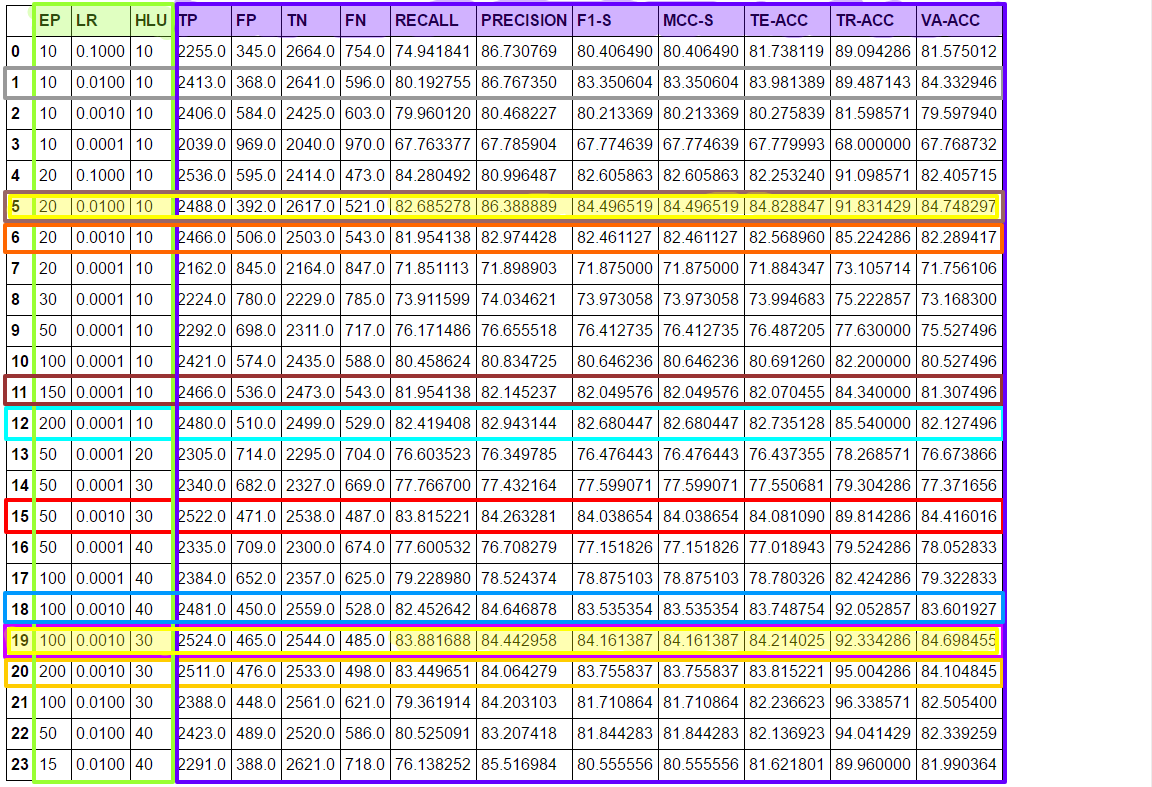

In [53]:
Image(filename='training/tables/results_final.png')

### Saved trained Model

In [ ]:
# save the model to disk
#model_trained_filepath = 'models/se_model_lr0.01epoch_25hlu_10.sav'
ensure_dir(model_trained_filepath)
cPickle.dump(nnetEffLN, open(model_trained_filepath, 'wb'))

### Load trained Model

In [10]:
# load the model from disk
model_trained_filepath = 'models/se_model_lr0.01epoch_20hlu_10.sav'
loaded_model = cPickle.load(open(model_trained_filepath, 'rb'))

#### Predict sentiment of unseen data

Ensure that the results for loaded model are same as for the pre-saved model

In [7]:
loaded_model.predict("This product sucks!! I bought it and it proved disgusting. Do not buy.")

array([ 0.00281025])

In [8]:
loaded_model.predict("I enjoyed it. It is a very awesome product")

array([ 0.95822964])

In [9]:
loaded_model.predict("I hate how this product was badly packaged. It was delivered while damaged")

array([ 0.28054857])

### Deploy saved trained Model

At this point the model can be deployed and distributed as a service. It can be deployed as a web application, mobile app, smart personal asistants such as `Google Now`,`Google Home`, `Amazon Echo` e.t.c.